<a href="https://colab.research.google.com/github/surajbhala/Multiclass-Text-Classification-with-H20-and-Flask/blob/main/Multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [2]:
!java -version

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [3]:
!pip install h2o

     |████████████████████████████████| 164.6MB 94kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.4-py2.py3-none-any.whl size=164670979 sha256=cbcb91a13f88e715a89ebcc01fb36c3937bf7013dee6d2a8a9046b24274449dc
  Stored in directory: /root/.cache/pip/wheels/65/f4/0d/c9bb958d70c2e015c968cb91cbd7f1b486933056d422337d75
Successfully built h2o


In [4]:
import pandas as pd
import numpy as np
import nltk
import re
import h2o
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from h2o.automl import H2OAutoML
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf2ao_ljw
  JVM stdout: /tmp/tmpf2ao_ljw/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf2ao_ljw/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_stl0ip
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
df = pd.read_csv("/content/drive/MyDrive/MultiClass Text Classification/consumer_compliants.zip",compression='zip',sep=',')

In [8]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [9]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

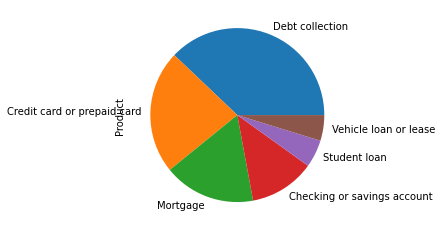

In [10]:
df['Product'].value_counts().plot(kind='pie')

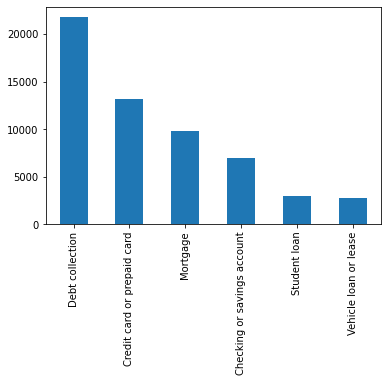

In [11]:
df['Product'].value_counts().plot(kind='bar')

In [12]:
df['Company'].value_counts()

CITIBANK, N.A.                                     3226
CAPITAL ONE FINANCIAL CORPORATION                  2711
BANK OF AMERICA, NATIONAL ASSOCIATION              2580
JPMORGAN CHASE & CO.                               2409
WELLS FARGO & COMPANY                              2001
                                                   ... 
Smith Debnam Narron Drake Saintsing & Myers LLP       1
Location Services Holdings, LLC                       1
Professional Claims Bureau, Inc.                      1
American Credit Financial                             1
Action Collection Service                             1
Name: Company, Length: 2197, dtype: int64

In [13]:
complaints_df = df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'Complaint'})

In [14]:
complaints_df.shape

(57453, 3)

In [15]:
target = {'Debt collection':0,'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan': 4,'Vehicle loan or lease':5}

In [16]:
complaints_df['target'] = complaints_df['Product'].map(target)

In [17]:
complaints_df.head()

,Complaint,Product,Company,target
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc.",0


In [18]:
X_train, X_test = train_test_split(complaints_df, test_size = 0.2, random_state = 42)

In [19]:
stemmer = nltk.stem.SnowballStemmer('english')

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [22]:
def tokenize(text):
  tokens =[word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+', '', word.strip('Xx/'))))]
  tokens = map(str.lower, tokens)
  stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [23]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False)

In [24]:
train_vectors = vectorizer_tf.fit_transform(X_train['Complaint'])

In [25]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.09353417, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
vectorizer_tf.get_feature_names()

['0.00',
 '100.00',
 '1000.00',
 '10000.00',
 '1100.00',
 '1200.00',
 '150.00',
 '1500.00',
 '200.00',
 '2000.00',
 '300.00',
 '3000.00',
 '400.00',
 '50.00',
 '500.00',
 '5000.00',
 'abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'ahead',
 'alert',
 'alleg',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'amex',
 'amount',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'apolog',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'appropri',
 'approv',
 'approxim',
 'area',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'asset',
 'assign',
 'assist',
 'associ',
 'assum',
 'ass

In [27]:
test_vectors = vectorizer_tf.transform(X_test['Complaint'])

In [28]:
train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df = pd.concat([train_df, X_train['target'].reset_index(drop=True)], axis = 1)
train_df

,0.00,100.00,1000.00,10000.00,1100.00,1200.00,150.00,1500.00,200.00,2000.00,300.00,3000.00,400.00,50.00,500.00,5000.00,abil,abl,absolut,abus,accept,access,accord,account,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,...,veteran,victim,view,violat,visa,visit,voic,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,went,whether,whole,wife,will,wire,wish,withdraw,within,without,woman,wont,word,work,worri,would,write,written,wrong,wrote,year,yesterday,zero,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.288861,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.082039,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.130855,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.103280,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.089328,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.091967,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.077270,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.033690,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.134970,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.442409,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.034026,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.032839,0.000000,0.023526,0.0,0.018505,0.0,0.0,0.020822,0.356791,0.020678,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.022091,0.0,0.0,0.0,0.0,0.000000,0.0,0.185122,0.024768,0.025928,0.0,0.0,0.016898,0.0,0.0,2
45958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.165633,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.24375,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,3
45959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.127020,0.0,0.0,0.0,0.0,0.000000,0.0,0

In [29]:
test_df = pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df = pd.concat([test_df, X_test['target'].reset_index(drop=True)], axis = 1)
test_df

,0.00,100.00,1000.00,10000.00,1100.00,1200.00,150.00,1500.00,200.00,2000.00,300.00,3000.00,400.00,50.00,500.00,5000.00,abil,abl,absolut,abus,accept,access,accord,account,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,...,veteran,victim,view,violat,visa,visit,voic,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,went,whether,whole,wife,will,wire,wish,withdraw,within,without,woman,wont,word,work,worri,would,write,written,wrong,wrote,year,yesterday,zero,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.222309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.046336,0.0,0.0,0.0,0.026111,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.049758,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.079482,0.0,0.0,0.0,0.074194,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.059485,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047155,0.000000,0.0,0.000000,0.000000,0.0,0.031088,0.0,0.000000,0.0,0.0,0.039727,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.056181,0.0,0.000000,0.0,0.00000,0.062778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.103068,0.000000,0.0,0.200725,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.288861,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.074424,0.0,0.0,0.000000,0.0,0.08717,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.046908,0.0,0.000000,0.0,0.0,0.119887,0.0,0.0,0
11487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.076181,0.0,0.00000,0.032096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.056546,0.0,0.000000,0.0,0.06057,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,5
11488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.370792,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000

In [30]:
## H2O AutoML 
## 
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
h2o_train_df.types

{'0.00': 'real',
 '100.00': 'real',
 '1000.00': 'real',
 '10000.00': 'real',
 '1100.00': 'real',
 '1200.00': 'real',
 '150.00': 'real',
 '1500.00': 'real',
 '200.00': 'real',
 '2000.00': 'real',
 '300.00': 'real',
 '3000.00': 'real',
 '400.00': 'real',
 '50.00': 'real',
 '500.00': 'real',
 '5000.00': 'real',
 'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'accord': 'real',
 'account': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'ahead': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alli': 'real',
 'allow': 'real',
 '

In [32]:
## As factor is done so that the target variable will be considered as an enumeration object and not an int 
## If target is considered as an integer, then the H2O will treat it as regression rather than classification
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()


In [33]:
h2o_train_df['target']

target
0
3
1
2
4
4
4
0
1
0


In [34]:
aml = H2OAutoML(max_models=10, seed=10, exclude_algos=['StackedEnsemble'], verbosity='info', nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [35]:
x = vectorizer_tf.get_feature_names()
y = 'target'

In [36]:
aml.train(x = x, y=y, training_frame=h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
07:42:18.701: Project: AutoML_20210226_74218697
07:42:18.701: Cross-validation disabled by user: no fold column nor nfolds > 1.
07:42:18.703: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
07:42:18.703: Build control seed: 10
07:42:18.703: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
07:42:24.566: training frame: Frame key: automl_training_py_1_sid_8664    cols: 1001    rows: 41253  chunks: 53    size: 33049549  checksum: -6356391559520261832
07:42:24.572: validation frame: Frame key: py_3_sid_8664    cols: 1001    rows: 11491  chunks: 14    size: 9195109  checksum: 6548790522519884080
07:42:24.851: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_8664    cols: 1001    rows: 4709  chunks: 53    size: 7376801  checksum: -8454385473706864236
07:42:24.851: blending frame: NULL
07:42:24.851: response 

In [37]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_2_AutoML_20210226_074218,0.152688,0.336882,0.311157,0.0968187,nan,nan
XGBoost_1_AutoML_20210226_074218,0.152726,0.335539,0.312812,0.0978516,nan,nan
XGBoost_3_AutoML_20210226_074218,0.156743,0.339574,0.318507,0.101447,nan,nan
GBM_5_AutoML_20210226_074218,0.157709,0.363503,0.32521,0.105762,nan,nan
GBM_3_AutoML_20210226_074218,0.157986,0.383021,0.334822,0.112106,nan,nan
GBM_4_AutoML_20210226_074218,0.161392,0.384202,0.335639,0.112653,nan,nan
GBM_2_AutoML_20210226_074218,0.164786,0.382555,0.33903,0.114941,nan,nan
GLM_1_AutoML_20210226_074218,0.170209,0.369061,0.330849,0.109461,nan,nan
GBM_1_AutoML_20210226_074218,0.175588,0.407444,0.351204,0.123344,nan,nan
DRF_1_AutoML_20210226_074218,0.310427,0.623701,0.45761,0.209407,nan,nan


In [38]:
pred = aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [39]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.09404872253120411
RMSE: 0.3066736417287996
LogLoss: 0.32436154620145546
Mean Per-Class Error: 0.15475439899136376
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4054.0,121.0,55.0,36.0,35.0,44.0,0.066974,"291 / 4,345"
1,170.0,2309.0,22.0,118.0,2.0,12.0,0.123054,"324 / 2,633"
2,71.0,26.0,1870.0,22.0,10.0,17.0,0.072421,"146 / 2,016"
3,42.0,148.0,14.0,1168.0,3.0,9.0,0.156069,"216 / 1,384"
4,63.0,23.0,23.0,1.0,456.0,10.0,0.208333,120 / 576
5,84.0,49.0,20.0,4.0,5.0,375.0,0.301676,162 / 537
6,4484.0,2676.0,2004.0,1349.0,511.0,467.0,0.109564,"1,259 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.890436
1,2,0.964320
2,3,0.985206
3,4,0.994517
4,5,0.998695
5,6,1.000000


In [42]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [43]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20210226_074218


Model Summary: 


,,number_of_trees
0,,80.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.02510037007354675
RMSE: 0.15843096311500082
LogLoss: 0.09910145332257556
Mean Per-Class Error: 0.03047920077727671
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,15469.0,100.0,39.0,24.0,14.0,10.0,0.011944,"187 / 15,656"
1,166.0,9252.0,9.0,33.0,7.0,7.0,0.023433,"222 / 9,474"
2,45.0,34.0,6903.0,7.0,0.0,3.0,0.012729,"89 / 6,992"
3,51.0,48.0,3.0,4947.0,0.0,2.0,0.020590,"104 / 5,051"
4,55.0,28.0,2.0,2.0,2017.0,3.0,0.042715,"90 / 2,107"
5,75.0,52.0,3.0,6.0,5.0,1832.0,0.071465,"141 / 1,973"
6,15861.0,9514.0,6959.0,5019.0,2043.0,1857.0,0.020192,"833 / 41,253"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.979808
1,2,0.994934
2,3,0.998279
3,4,0.999539
4,5,0.999903
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09404872253120411
RMSE: 0.3066736417287996
LogLoss: 0.32436154620145546
Mean Per-Class Error: 0.15475439899136376
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4054.0,121.0,55.0,36.0,35.0,44.0,0.066974,"291 / 4,345"
1,170.0,2309.0,22.0,118.0,2.0,12.0,0.123054,"324 / 2,633"
2,71.0,26.0,1870.0,22.0,10.0,17.0,0.072421,"146 / 2,016"
3,42.0,148.0,14.0,1168.0,3.0,9.0,0.156069,"216 / 1,384"
4,63.0,23.0,23.0,1.0,456.0,10.0,0.208333,120 / 576
5,84.0,49.0,20.0,4.0,5.0,375.0,0.301676,162 / 537
6,4484.0,2676.0,2004.0,1349.0,511.0,467.0,0.109564,"1,259 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.890436
1,2,0.964320
2,3,0.985206
3,4,0.994517
4,5,0.998695
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-02-26 07:44:07,0.024 sec,0.0,0.833333,1.791759,0.830509,NaN,NaN,0.833333,1.791759,0.824558,NaN,NaN
1,,2021-02-26 07:44:29,22.007 sec,5.0,0.449595,0.609418,0.111216,NaN,NaN,0.470541,0.659430,0.139936,NaN,NaN
2,,2021-02-26 07:44:46,38.679 sec,10.0,0.334620,0.372929,0.090660,NaN,NaN,0.375207,0.454751,0.127230,NaN,NaN
3,,2021-02-26 07:45:02,54.257 sec,15.0,0.289097,0.283375,0.075898,NaN,NaN,0.344009,0.387593,0.118876,NaN,NaN
4,,2021-02-26 07:45:17,1 min 10.063 sec,20.0,0.262377,0.235609,0.064941,NaN,NaN,0.329512,0.358671,0.115395,NaN,NaN
5,,2021-02-26 07:45:34,1 min 26.573 sec,25.0,0.244627,0.206436,0.056529,NaN,NaN,0.321421,0.342489,0.113567,NaN,NaN
6,,2021-02-26 07:45:51,1 min 43.755 sec,30.0,0.230488,0.185462,0.050227,NaN,NaN,0.316896,0.334181,0.112871,NaN,NaN
7,,2021-02-26 07:46:09,2 min 1.820 sec,35.0,0.219944,0.170530,0.045039,NaN,NaN,0.313763,0.329350,0.111304,NaN,NaN
8,,2021-02-26 07:46:28,2 min 20.814 sec,40.0,0.210649,0.158120,0.041524,NaN,NaN,0.311350,0.325906,0.110173,NaN,NaN
9,,2021-02-26 07:46:48,2 min 40.205 sec,45.0,0.201511,0.146683,0.037137,NaN,NaN,0.310083,0.324254,0.109129,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,debt,16785.566406,1.000000,0.108695
1,mortgag,14418.546875,0.858985,0.093368
2,card,12643.182617,0.753218,0.081871
3,loan,9519.051758,0.567097,0.061641
4,bank,6701.005371,0.399212,0.043393
5,collect,4449.286133,0.265066,0.028811
6,credit,4298.848145,0.256104,0.027837
7,payment,3703.797119,0.220654,0.023984
8,student,3467.434326,0.206572,0.022453
9,account,3343.997070,0.199219,0.021654



See the whole table with table.as_data_frame()


In [44]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_delta_step': 0.0,
  'max_depth': 20,
  'min_child_weight': 10.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 11,
  'silent': True,
  'subsample': 0.6,
  'tree_method': 'exact'},
 10000)

In [45]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
xgb_clf = xgb.XGBClassifier(booster = 'gbtree', colsample_bylevel = 0.8,
  colsample_bytree =  0.8, eta = 0.3, grow_policy = 'depthwise', max_depth = 20, min_child_weight = 10.0, nround = 10000,
   nthread = 2,  num_class = 6,  objective = 'multi:softprob', seed = 11,
   silent = True,  subsample = 0.6, tree_method = 'exact', **{"updater":"grow_gpu"})

In [51]:
xgb_clf.fit(train_vectors, X_train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
              grow_policy='depthwise', learning_rate=0.1, max_delta_step=0,
              max_depth=20, min_child_weight=10.0, missing=None,
              n_estimators=100, n_jobs=1, nround=10000, nthread=2, num_class=6,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=11, silent=True,
              subsample=0.6, tree_method='exact', verbosity=1)

In [53]:
predictions = xgb_clf.predict(test_vectors)

In [54]:
confusion_matrix(X_test['target'], predictions)

array([[4041,  128,   59,   37,   34,   46],
       [ 157, 2334,   15,  116,    2,    9],
       [  75,   33, 1869,   17,    9,   13],
       [  42,  137,   18, 1179,    1,    7],
       [  50,   23,   19,    1,  472,   11],
       [  90,   51,   14,    7,    9,  366]])

In [55]:
print(classification_report(X_test['target'], predictions))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4345
           1       0.86      0.89      0.87      2633
           2       0.94      0.93      0.93      2016
           3       0.87      0.85      0.86      1384
           4       0.90      0.82      0.86       576
           5       0.81      0.68      0.74       537

    accuracy                           0.89     11491
   macro avg       0.88      0.85      0.86     11491
weighted avg       0.89      0.89      0.89     11491



In [56]:
## Compute class weights based on target dataset target variable.

from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(X_train['target']), X_train['target']))

In [57]:
class_weight

<module 'sklearn.utils.class_weight' from '/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.py'>

In [58]:
weights = np.ones(X_train.shape[0], dtype='float')

In [59]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [60]:
for i, val in enumerate(X_train['target']):
  weights[i] = class_weights[val]
  

In [61]:
weights

array([0.43956696, 1.36329121, 0.72541035, ..., 0.72541035, 0.43956696,
       0.98423915])